In [1]:
!gdown --id 1-5EJI4c44Ju7dSi77QPW6bV5O16hcwdW
!unzip archive.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1-5EJI4c44Ju7dSi77QPW6bV5O16hcwdW
To: /content/archive.zip
100% 436M/436M [00:05<00:00, 80.7MB/s]
Archive:  archive.zip
  inflating: annotations/defect_free/1.txt  
  inflating: annotations/defect_free/10.txt  
  inflating: annotations/defect_free/11.txt  
  inflating: annotations/defect_free/12.txt  
  inflating: annotations/defect_free/13.txt  
  inflating: annotations/defect_free/14.txt  
  inflating: annotations/defect_free/15.txt  
  inflating: annotations/defect_free/16.txt  
  inflating: annotations/defect_free/17.txt  
  inflating: annotations/defect_free/18.txt  
  inflating: annotations/defect_free/19.txt  
  inflating: annotations/defect_free/2.txt  
  inflating: annotations/defect_free/20.txt  
  inflating: ann

In [2]:
!pip install pytorch-lightning
!pip install -q pytorch-metric-learning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 720.6/720.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 64.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 4.0 MB/s eta 0:00:00


# PUBLICZNY ZBIÓR DANYCH

## Dane


In [3]:
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image
from torchvision.transforms import Compose

class StainDataset(Dataset):
  n_classes = 2
  class_names = ["stain", "defect free"]
  class_folder_names = {"stain": "stain", "defect free": "defect_free"}

  def __init__(self, path:str, transform:Compose):
    super().__init__()
    assert os.path.exists(path)
    self.path = path
    self.transform = transform
    self.images = []

    for class_name in self.class_names:
      class_folder_path = os.path.join(self.path, self.class_folder_names[class_name])
      assert os.path.exists(class_folder_path)
      for image_file in os.scandir(path=class_folder_path):
        self.images.append((image_file, self.class_names.index(class_name)))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, ndx):
    image = np.asarray(Image.open(os.path.join(self.images[ndx][0])))
    if self.transform is not None:
      image = self.transform(image)
    return image, self.images[ndx][1]

In [4]:
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize

dataset = StainDataset(path="images", transform=Compose([ToPILImage(), Resize((32, 32)), ToTensor()]))

## Podział danych na testowy, treningowy, walidacyjny

In [5]:
import torch
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    range(len(dataset)),
    test_size=0.3,
    random_state=42
)

# Podział indeksów zbioru treningowego na zbiór treningowy (80%) i walidacyjny (20%)
train_indices, val_indices = train_test_split(
    train_indices,
    test_size=0.2,
    random_state=42
)

# Utworzenie odpowiednich zbiorów danych na podstawie indeksów
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

In [6]:
from torch.utils.data import DataLoader

# Utworzenie obiektów DataLoader dla każdego zbioru
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
import pytorch_lightning as pl
from torch import nn
from torch.optim import Adam
from torch.utils.data import Subset
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from sklearn.model_selection import train_test_split
from pytorch_metric_learning.miners import BatchHardMiner
from pytorch_metric_learning.losses import TripletMarginLoss

In [8]:
class ModelLearner(pl.LightningModule):
    def __init__(self, model: nn.Module, margin=0.2):
        super().__init__()
        self.save_hyperparameters()
        self.model = model
        self.margin = margin
        self.miner = BatchHardMiner()
        self.loss = TripletMarginLoss(margin=self.margin)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, labels = batch
        embeddings = self.forward(x)
        triplets = self.miner(embeddings, labels)
        loss = self.loss(embeddings, labels, triplets)
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)

# Model

In [9]:
class VGG16(nn.Module):
    def __init__(self, in_channels=3, embedding_size = 128):
        super(VGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.embedding_layer = nn.Sequential(
            nn.Linear(512 * 7 * 7, embedding_size),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        embeddings = self.embedding_layer(x)
        return embeddings

In [10]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"CUDA jest dostępna. Używany jest urządzenie CUDA: {torch.cuda.get_device_name(device)}")
else:
    print("CUDA nie jest dostępna. Wykorzystywane będzie CPU.")

CUDA jest dostępna. Używany jest urządzenie CUDA: Tesla T4


## Zadanie reidentyfikacji

In [11]:
# Trenowanie
model = VGG16(1, 128)
model = model.to("cuda")

learner = ModelLearner(model)
learner = learner.to("cuda")

trainer = pl.Trainer(max_epochs=10, log_every_n_steps=1)
trainer.fit(learner, train_dataloader, val_dataloaders=val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | VGG16             | 17.9 M
1 | miner | BatchHardMiner    | 0     
2 | loss  | TripletMarginLoss | 0     
--------------------------------------------
17.9 M 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


# Testowanie

In [ ]:
model = model.to("cuda")

test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

total_loss = 0.0
correct = 0
total = 0

model.eval()

criterion = nn.CrossEntropyLoss()

for batch in test_dataloader:
    images, labels = batch
    images = images.to("cuda")
    labels = labels.to("cuda")

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)

    loss = criterion(outputs, labels)
    total_loss += loss.item()

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

avg_loss = total_loss / len(test_dataloader)
accuracy = 100 * correct / total

print("Test Loss: {:.4f}".format(avg_loss))
print("Test Accuracy: {:.2f}%".format(accuracy))

Test Loss: 4.8706
Test Accuracy: 0.00%


In [12]:
def compute_embeddings(model, dataset):
  model.eval()
  embeddings = None
  data = {}
  for ndx, (x, x_lab) in enumerate(dataset):
    x = x.unsqueeze(0).contiguous()
    with torch.no_grad():
      y = model(x).squeeze(0)
    if embeddings is None:
      embeddings = torch.zeros((len(dataset), y.shape[0]), dtype=y.dtype)
    embeddings[ndx] = y
    data[ndx] = (x, x_lab)
  return embeddings, data

def find_nearest_neighbours(embeddings, query_ndx, k=10):
  y = embeddings[query_ndx]
  dist = torch.norm(embeddings-y, p=2, dim=1)
  values, nn_ndx = torch.topk(dist, k+1, largest=False, sorted=True)
  nn_ndx = nn_ndx[1:]
  return nn_ndx, dist[nn_ndx]

In [14]:
embeddings, oryginal_data = compute_embeddings(model, test_dataset)

In [15]:
ndx, (x, x_lab) = list(enumerate(test_dataset))[0]
ndx_p, p = find_nearest_neighbours(embeddings, ndx)
print("Image class ", oryginal_data[ndx][1])
print("Nearest neighbours class ", oryginal_data[ndx_p[0].item()][1])

Image class  0
Nearest neighbours class  0


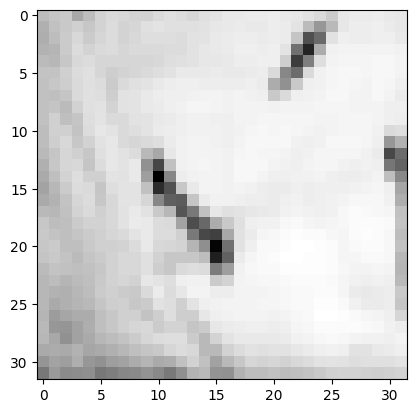

In [16]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

plt.imshow(oryginal_data[ndx][0][0][0], cmap='gray')
plt.show()

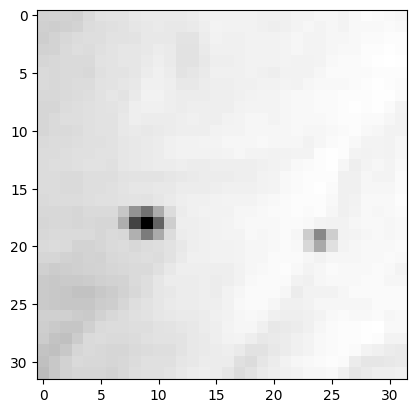

In [17]:
plt.imshow(oryginal_data[ndx_p[0].item()][0][0][0], cmap='gray')
plt.show()

## Zadanie klasyfikacji

In [ ]:
class VGG16Classifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(VGG16Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
            # nn.Linear(4096, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        outputs = self.classifier(x)
        return outputs

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG16Classifier(in_channels=1, num_classes=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCEWithLogitsLoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        # labels = labels.float().view(-1, 1)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        # rounded_outputs = torch.round(torch.sigmoid(outputs))
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        # correct += rounded_outputs.eq(labels.float().view(-1, 1)).sum().item()

    train_loss /= len(train_dataloader)
    train_accuracy = 100.0 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # labels = labels.float().view(-1, 1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            # rounded_outputs = torch.round(torch.sigmoid(outputs))
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            # correct += rounded_outputs.eq(labels.float().view(-1, 1)).sum().item()


    val_loss /= len(val_dataloader)
    val_accuracy = 100.0 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/10 | Train Loss: 0.4771 | Train Accuracy: 78.85% | Val Loss: 0.3598 | Val Accuracy: 90.91%
Epoch 2/10 | Train Loss: 0.4855 | Train Accuracy: 85.77% | Val Loss: 0.3534 | Val Accuracy: 90.91%
Epoch 3/10 | Train Loss: 0.4176 | Train Accuracy: 85.77% | Val Loss: 0.2872 | Val Accuracy: 90.91%
Epoch 4/10 | Train Loss: 0.4450 | Train Accuracy: 85.77% | Val Loss: 0.2422 | Val Accuracy: 90.91%
Epoch 5/10 | Train Loss: 0.3993 | Train Accuracy: 85.77% | Val Loss: 0.2878 | Val Accuracy: 90.91%
Epoch 6/10 | Train Loss: 0.3812 | Train Accuracy: 85.77% | Val Loss: 0.2553 | Val Accuracy: 90.91%
Epoch 7/10 | Train Loss: 0.4407 | Train Accuracy: 85.77% | Val Loss: 0.2542 | Val Accuracy: 90.91%
Epoch 8/10 | Train Loss: 0.3981 | Train Accuracy: 85.77% | Val Loss: 0.2969 | Val Accuracy: 90.91%
Epoch 9/10 | Train Loss: 0.4440 | Train Accuracy: 85.77% | Val Loss: 0.2540 | Val Accuracy: 90.91%
Epoch 10/10 | Train Loss: 0.3906 | Train Accuracy: 85.77% | Val Loss: 0.2780 | Val Accuracy: 90.91%


In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_dataloader)
test_accuracy = 100.0 * correct / total

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 2.3026 | Test Accuracy: 82.14%


Inny testowy model

In [ ]:
import torch.nn.functional as F

class MLPClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(32*32, 128)
        self.layer_2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        x = F.relu(x)
        x = self.layer_2(x)
        return x

In [ ]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
model = ModelLearner(MLPClassifier())

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:196: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
trainer_MLP = pl.Trainer(max_epochs=10)
trainer_MLP.fit(model, dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:70: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type              | Params
--------------------------------------------
0 | model | MLPClassifier     | 132 K 
1 | miner | BatchHardMiner    | 0     
2 | loss  | TripletMarginLoss | 0     
--------------------------------------------
132 K     Trainable params
0         Non-trainable params
132 K     Total params
0

Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/call.py:52: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


# WŁASNY ZBIÓR DANYCH

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")

path = '/content/drive/My Drive/ASO_dataset'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
folder_path = '/content/drive/MyDrive/ASO_dataset/free'

if os.path.exists(folder_path):
    print("Folder istnieje")
else:
    print("Folder nie istnieje")

Folder istnieje


In [ ]:
from PIL import Image
import os

In [ ]:
folder_path_stain = '/content/drive/MyDrive/ASO_dataset/stain'
for filename in os.listdir(folder_path_stain):
    if any(filename.endswith(ext) for ext in ['.png', '.jpg']):
        file_path = os.path.join(folder_path_stain, filename)


        img = Image.open(file_path)
        new_file_path = os.path.splitext(file_path)[0] + ".jpg"
        img.save(new_file_path, "JPEG")
        img.close()
        os.remove(file_path)

In [ ]:
folder_path_free = '/content/drive/MyDrive/ASO_dataset/free'
for filename in os.listdir(folder_path_free):
    if any(filename.endswith(ext) for ext in ['.png', '.jpg']):
        file_path = os.path.join(folder_path_free, filename)

        img = Image.open(file_path)
        new_file_path = os.path.splitext(file_path)[0] + ".jpg"
        img.save(new_file_path, "JPEG")
        img.close()
        os.remove(file_path)

In [ ]:
from torch.utils.data import Dataset
import os
import numpy as np
from PIL import Image
from torchvision.transforms import Compose

class StainDataset(Dataset):
    n_classes = 2
    class_names = ["stain", "free"]
    class_folder_names = {"stain": "stain", "free": "free"}

    def __init__(self, path:str, transform: Compose):
        super().__init__()
        assert os.path.exists(path)
        self.transform = transform
        self.images = []


        for class_name in self.class_names:
            class_folder_path = os.path.join(path, self.class_folder_names[class_name])
            assert os.path.exists(class_folder_path)
            for image_file in os.scandir(path=class_folder_path):
              self.images.append((image_file, self.class_names.index(class_name)))


    def __len__(self):
        return len(self.images)

    def __getitem__(self, ndx):
      image = np.asarray(Image.open(os.path.join(self.images[ndx][0])))
      if self.transform is not None:
        image = self.transform(image)
      return image, self.images[ndx][1]

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize

dataset_own = StainDataset(path=path, transform=Compose([ToPILImage(), Resize((32, 32)), ToTensor()]))

In [ ]:
import torch
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split

train_indices, test_indices = train_test_split(
    range(len(dataset_own)),
    test_size=0.3,
    random_state=42
)

train_indices, val_indices = train_test_split(
    train_indices,
    test_size=0.2,
    random_state=42
)

train_dataset_own = torch.utils.data.Subset(dataset_own, train_indices)
val_dataset_own = torch.utils.data.Subset(dataset_own, val_indices)
test_dataset_own = torch.utils.data.Subset(dataset_own, test_indices)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader_own = DataLoader(train_dataset_own, batch_size=32, shuffle=True)
val_dataloader_own = DataLoader(val_dataset_own, batch_size=32, shuffle=False)
test_dataloader_own = DataLoader(test_dataset_own, batch_size=32, shuffle=False)

In [ ]:
if torch.cuda.is_available():
    device = torch.cuda.current_device()
    print(f"CUDA jest dostępna. Używany jest urządzenie CUDA: {torch.cuda.get_device_name(device)}")
else:
    print("CUDA nie jest dostępna. Wykorzystywane będzie CPU.")

CUDA jest dostępna. Używany jest urządzenie CUDA: Tesla T4


In [ ]:
class VGG16Classifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=2):
        super(VGG16Classifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AdaptiveAvgPool2d((7, 7))
        )

        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
            # nn.Linear(4096, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        outputs = self.classifier(x)
        return outputs

In [ ]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = VGG16Classifier(in_channels=3, num_classes=2)
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader_own:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss /= len(train_dataloader)
    train_accuracy = 100.0 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_dataloader_own:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()


    val_loss /= len(val_dataloader)
    val_accuracy = 100.0 * correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
          f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/10 | Train Loss: 0.0777 | Train Accuracy: 0.00% | Val Loss: 0.2184 | Val Accuracy: 100.00%
Epoch 2/10 | Train Loss: 0.0730 | Train Accuracy: 100.00% | Val Loss: 0.2022 | Val Accuracy: 100.00%
Epoch 3/10 | Train Loss: 0.0677 | Train Accuracy: 100.00% | Val Loss: 0.1807 | Val Accuracy: 100.00%
Epoch 4/10 | Train Loss: 0.0609 | Train Accuracy: 100.00% | Val Loss: 0.1520 | Val Accuracy: 100.00%
Epoch 5/10 | Train Loss: 0.0507 | Train Accuracy: 100.00% | Val Loss: 0.1152 | Val Accuracy: 100.00%
Epoch 6/10 | Train Loss: 0.0390 | Train Accuracy: 100.00% | Val Loss: 0.0726 | Val Accuracy: 100.00%
Epoch 7/10 | Train Loss: 0.0250 | Train Accuracy: 100.00% | Val Loss: 0.0320 | Val Accuracy: 100.00%
Epoch 8/10 | Train Loss: 0.0104 | Train Accuracy: 100.00% | Val Loss: 0.0066 | Val Accuracy: 100.00%
Epoch 9/10 | Train Loss: 0.0024 | Train Accuracy: 100.00% | Val Loss: 0.0003 | Val Accuracy: 100.00%
Epoch 10/10 | Train Loss: 0.0001 | Train Accuracy: 100.00% | Val Loss: 0.0000 | Val Accuracy:

In [ ]:
model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_dataloader_own:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= len(test_dataloader)
test_accuracy = 100.0 * correct / total

print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.0084 | Test Accuracy: 66.67%
